In [16]:
import Bio
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Restriction import BsaI, BbsI, EcoRV, SphI, XbaI
from Bio.Data import CodonTable
from Bio.SeqUtils import MeltingTemp as mt
from pydna.genbank import Genbank
from Bio import Entrez
from Bio.Restriction import BsaI
from pydna.dseq import Dseq
from Bio.SeqFeature import SeqFeature
from Bio.SeqFeature import FeatureLocation
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pydna
import re

In [2]:
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
codon_dict = standard_table.forward_table
# Add stop codons
codon_dict['TAA'] = '*'
codon_dict['TAG'] = '*'
codon_dict['TGA'] = '*'
codons = codon_dict.keys()

In [3]:
CODON_DF = pd.read_csv('../library_design/codon_df.csv')

In [4]:
# Reading in barcode sequences
with open('../library_design/barcodes.txt', 'r') as f: 
    barcodes = f.readlines()       
barcodes = [x.strip() for x in barcodes]
print (len(barcodes[0]))
print (len(barcodes))

20
250000


In [5]:
# Calculate length of rep/AAV sequence to be included in each tile based off of oligo and flanking sequence length
SKPP_LEN = 15 
BSAI_OH_LEN = 5
BBSI_OH_LEN = 6 
BSAI_LEN = 6
BBSI_LEN = 6
ECORV_LEN = 6
BARCODE_LEN = 20
CHIP_LEN = 300
BSAI_PRIMER_OH_LEN = 6 
BBSI_PRIMER_OH_LEN = 7 

CONSTRAINTS_LEN = (SKPP_LEN + BSAI_LEN + BBSI_LEN + ECORV_LEN + BBSI_LEN + BBSI_OH_LEN + BARCODE_LEN + BSAI_OH_LEN + BSAI_LEN + SKPP_LEN)

AAV_LEN = CHIP_LEN - CONSTRAINTS_LEN

while AAV_LEN % 3 != 0:
    AAV_LEN -= 1 

TOTAL_LEN = AAV_LEN + CONSTRAINTS_LEN

# Only making substitutions and deletions so can include 3 nt more per tile
while TOTAL_LEN > CHIP_LEN:
    AAV_LEN -= 3 
    TOTAL_LEN = AAV_LEN + CONSTRAINTS_LEN
    
# print (AAV_LEN/3)
# print (AAV_LEN + CONSTRAINTS_LEN)

assert (AAV_LEN % 3 == 0)
assert (TOTAL_LEN <= CHIP_LEN)

print (AAV_LEN)
print (CONSTRAINTS_LEN)

207
91


In [6]:
# These are the sites used for the two clonings 
BSAI_5 = str(Seq(BsaI.site).reverse_complement())
BSAI_3 = str(Seq(BsaI.site))
BBSI_5 = str(Seq(BbsI.site).reverse_complement())
BBSI_3 = str(Seq(BbsI.site))
ECORV =  str(Seq(EcoRV.site))
SPHI =  str(Seq(SphI.site))
XBAI =  str(Seq(XbaI.site))

ENZYMES_SITES = [BSAI_3, BSAI_5, BBSI_3, BBSI_5, ECORV, SPHI, XBAI]
ENZYMES_SITES

['GGTCTC', 'GAGACC', 'GAAGAC', 'GTCTTC', 'GATATC', 'GCATGC', 'TCTAGA']

In [7]:
# Get backbone plasmid for wtaav2 library cloning as GenBank file
BACKBONE_PLASMID = SeqIO.read(open('../library_design/pNJ144.gb'), 'genbank')

BACKBONE_PLASMID[1983:2003]

rep78_68_start = 51
rep78_52_end = 1917
rep52_40_start = 723
rep68_40_end = 1983

# Including 6 nt flanking start and stop codons for BsaI overhangs, do not mutate region of Rep68/40 that overlaps VP1 ORF
AAV2_REP = str(BACKBONE_PLASMID[rep78_68_start-6:rep78_52_end+6].seq)
len(AAV2_REP)

/home/ubuntu/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '4188..41' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '<4930..>41' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(


1878

In [8]:
# Get backbone plasmid for pCMV-rep78/68 library cloning as GenBank file
REP78_68_BACKBONE_PLASMID = SeqIO.read(open('../library_design/pNJ152.gb'), 'genbank')

# Get backbone plasmid containing only rep78 coding sequence as GenBank file
REP78_BACBKBONE_PLASMID = SeqIO.read(open('../library_design/pNJ153.gb'), 'genbank')

/home/ubuntu/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '3947..>1037' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '2002..31' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '<2744..>25' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '3947..31' as it looks like incorrect origin wrapping. Please fix input

In [9]:
# Pull out coding sequence from Rep78 expression plasmid, this range includes 6 nt on either side of coding region
# Will use this sequence to design tiles 11, 12, and 13, which correspond to tile 3 with M225G, tile 4 with M225G,
# and tile 9 with splice donor mutation
REP78 = str(REP78_BACBKBONE_PLASMID[76:1964].seq)
REP78

'GCCGCCATGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCGACCTTGACGAGCATCTGCCCGGCATTTCTGACAGCTTTGTGAACTGGGTGGCCGAGAAGGAATGGGAGTTGCCGCCAGATTCTGACATGGATCTGAATCTGATTGAGCAGGCACCCCTGACCGTGGCCGAGAAGCTGCAGCGCGACTTTCTGACGGAATGGCGCCGTGTGAGTAAGGCCCCGGAGGCTCTTTTCTTTGTGCAATTTGAGAAGGGAGAGAGCTACTTCCACATGCACGTGCTCGTGGAAACCACCGGGGTGAAATCCATGGTTTTGGGACGTTTCCTGAGTCAGATTCGCGAAAAACTGATTCAGAGAATTTACCGCGGGATCGAGCCGACTTTGCCAAACTGGTTCGCGGTCACAAAGACCAGAAATGGCGCCGGAGGCGGGAACAAGGTGGTGGATGAGTGCTACATCCCCAATTACTTGCTCCCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAACAGTATTTAAGCGCCTGTTTGAATCTCACGGAGCGTAAACGGTTGGTGGCGCAGCATCTGACGCACGTGTCGCAGACGCAGGAGCAGAACAAAGAGAATCAGAATCCCAATTCTGATGCGCCGGTGATCAGATCAAAAACTTCAGCCAGGTACGGAGAGCTGGTCGGGTGGCTCGTGGACAAGGGGATTACCTCGGAGAAGCAGTGGATCCAGGAGGACCAGGCCTCATACATCTCCTTCAATGCGGCCTCCAACTCGCGGTCCCAAATCAAGGCTGCCTTGGACAATGCGGGAAAGATTATGAGCCTGACTAAAACCGCCCCCGACTACCTGGTGGGCCAGCAGCCCGTGGAGGACATTTCCAGCAATCGGATTTATAAAATTTTGGAACTAAACGGGTACGATCCCCAATATGCGGCTTCCGTCTTTCTGGGATGGGCCACGAAAAAGTTCGGCAAGAGGAACACCATCTGG

In [10]:
def check_overhangs_self_ligation(wt_tile):
    # assumes we're using a 4 bp overhang enzyme
    overhang1 = wt_tile[1:BSAI_OH_LEN]
    overhang2 = wt_tile[-BBSI_OH_LEN:-2]
    print (overhang1, overhang2)
#     print "--------"
  
    return overhang1 == overhang2

# get_tiles takes a wt_seq as input, wt_seq should contain spacers sequences on either side
# spacer sequences should be 6 nt
# spacer_length is the length of these overhangs
# tile_target_length is the total length of the rep sequence to be included in the tile (includes both mutated and constant pos)
# mut_end is the pos in wt_seq where mutations should stop, if not specified function assumes it should mutate to last aa pos
# get_tiles returns df with:
# tile_start: starting nucleotide of given tile indexed from beginning of wt_seq,
# tile_end: ending nucelotide of given tile indexed from beginning of wt_seq,
# library_start: nucleotide position in tile where mutations start,
# library_end: nucleotide position in tile where mutations end,
# lib_aa_start: position of first aa in this tile that is mutated,
# lib_aa_end: position of last aa in this tile that is mutated,
# tile_seq: wt tile sequence
def get_tiles(wt_seq, tile_target_length, spacer_length, tile_shift = 3, mut_end = None):

    tile_obj = []
    tile_start = 0
    tile_end = 0
    while tile_end < len(wt_seq):
        
        tile_end = tile_start + tile_target_length
        
#         tile_aa_start = (tile_start - spacer_length) / 3
#         print (tile_aa_start)
#         print (tile_aa_start.is_integer())
#         print (spacer_length)
    
        library_start = tile_start + spacer_length - 1 # mutations start spacer_length after tile_start and at beg. of a codon
        while (library_start - spacer_length) % 3 != 0:
            library_start += 1
            
#         print (tile_start, library_start)
        
        library_end = tile_end - spacer_length # mutations end spacer_length before end of tile and at end of a codon
        while (library_end - spacer_length) % 3 != 0:
            library_end -= 1
        
        # For the last tile, move tile_start back so tile is same length as the others but keep library_start the same
        if tile_end > len(wt_seq):
#             print (tile_end)
            tile_end = len(wt_seq)
#             print (tile_end)
            tile_start = tile_end - tile_target_length + 1
            if mut_end:
                library_end = mut_end
            else:
                library_end = tile_end - spacer_length
        
        tile_seq = wt_seq[tile_start:tile_end]
            
        lib_aa_start = (library_start - spacer_length) / 3 + 1
        lib_aa_end = (library_end - spacer_length) / 3
        
#         print (tile_start, tile_end, library_start, library_end, lib_aa_start, lib_aa_end)

        if check_overhangs_self_ligation(str(tile_seq)):
            print ('ERROR, overhangs not compatible')
            print ([tile_start, tile_end])
            print (tile_seq)
            exit()

        tile_obj.append({'tile': tile_seq,
                         'tile_start': tile_start,
                         'tile_end': tile_end,
                         'library_start': library_start - tile_start,
                         'library_end': library_end - tile_start,
                         'lib_aa_start': lib_aa_start,
                         'lib_aa_end': lib_aa_end})
        # increment tile_start to (codon + spacer_length) before last mutated codon in this tile
        tile_start = library_end - 3 - spacer_length 
        
    return pd.DataFrame(tile_obj)

tile_df = get_tiles(AAV2_REP, AAV_LEN, BBSI_OH_LEN)
tile_df

CCGC GAAT
TTCT AACT
CTTT ACGC
AGCA AACT
CGGC AAAA
GGGC GTCG
CCGC CTCA
AATT CAGC
CAGT CAAC
TTCA ATGA


,tile,tile_start,tile_end,library_start,library_end,lib_aa_start,lib_aa_end
0,GCCGCCATGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,207,6,201,1.0,65.0
1,TTTCTGACGGAATGGCGCCGTGTGAGTAAGGCCCCGGAGGCCCTTT...,192,399,6,201,65.0,129.0
2,ACTTTGCCAAACTGGTTCGCGGTCACAAAGACCAGAAATGGCGCCG...,384,591,6,201,129.0,193.0
3,CAGCATCTGACGCACGTGTCGCAGACGCAGGAGCAGAACAAAGAGA...,576,783,6,201,193.0,257.0
4,GCGGCCTCCAACTCGCGGTCCCAAATCAAGGCTGCCTTGGACAATG...,768,975,6,201,257.0,321.0
5,TGGGCCACGAAAAAGTTCGGCAAGAGGAACACCATCTGGCTGTTTG...,960,1167,6,201,321.0,385.0
6,ACCGCCAAGGTCGTGGAGTCGGCCAAAGCCATTCTCGGAGGAAGCA...,1152,1359,6,201,385.0,449.0
7,AAATTTGAACTCACCCGCCGTCTGGATCATGACTTTGGGAAGGTCA...,1344,1551,6,201,449.0,513.0
8,TCAGTTGCGCAGCCATCGACGTCAGACGCGGAAGCTTCGATCAACT...,1536,1743,6,201,513.0,577.0
9,ATTCAAATATCTGCTTCACTCACGGACAGAAAGACTGTTTAGAGTG...,1672,1878,62,200,577.0,622.0


In [11]:
# Manually fix tile 4 and on boundaries so that tile 4 starts at Rep52/40 start codon
tile_df_corrected = pd.DataFrame({'tile_start': [0, 192, 384, 480, 672, 864, 1056, 1248, 1383, 1575, 1671],
                                  'tile_end': [207, 399, 591, 687, 879, 1071, 1263, 1455, 1590, 1782, 1878],
                                  'library_start': [6, 6, 6, 102, 6, 6, 6, 6, 63, 6, 102],
                                  'library_end': [201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201],
                                  'lib_aa_start': [1, 65, 129, 193, 225, 289, 353, 417, 481, 526, 558],
                                  'lib_aa_end': [65, 129, 193, 225, 289, 353, 417, 481, 526, 558, 622], 
                                  'tile': [AAV2_REP[0:207], AAV2_REP[192:399], AAV2_REP[384:591], AAV2_REP[480:687],
                                          AAV2_REP[672:879], AAV2_REP[864:1071], AAV2_REP[1056:1263], AAV2_REP[1248:1455],
                                          AAV2_REP[1383:1590], AAV2_REP[1575:1782], AAV2_REP[1671:1878]]})
tile_df_corrected

,tile_start,tile_end,library_start,library_end,lib_aa_start,lib_aa_end,tile
0,0,207,6,201,1,65,GCCGCCATGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...
1,192,399,6,201,65,129,TTTCTGACGGAATGGCGCCGTGTGAGTAAGGCCCCGGAGGCCCTTT...
2,384,591,6,201,129,193,ACTTTGCCAAACTGGTTCGCGGTCACAAAGACCAGAAATGGCGCCG...
3,480,687,102,201,193,225,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...
4,672,879,6,201,225,289,AGGTACATGGAGCTGGTCGGGTGGCTCGTGGACAAGGGGATTACCT...
5,864,1071,6,201,289,353,CAGCAGCCCGTGGAGGACATTTCCAGCAATCGGATTTATAAAATTT...
6,1056,1263,6,201,353,417,GTGCCCTTCTACGGGTGCGTAAACTGGACCAATGAGAACTTTCCCT...
7,1248,1455,6,201,417,481,CCCGTGATCGTCACCTCCAACACCAACATGTGCGCCGTGATTGACG...
8,1383,1590,63,201,481,526,AAGGTCACCAAGCAGGAAGTCAAAGACTTTTTCCGGTGGGCAAAGG...
9,1575,1782,6,201,526,558,ATCAACTACGCAGACAGGTACCAAAACAAATGTTCTCGTCACGTGG...


In [12]:
# Get WT tile sequences from Rep78, will use this to design alternative oligos for tiles 3, 4 and 9 with M225G or splice donor mt
rep78_tile_df = pd.DataFrame({'tile_start': [0, 192, 384, 480, 672, 864, 1056, 1248, 1383, 1575, 1671],
                                  'tile_end': [207, 399, 591, 687, 879, 1071, 1263, 1455, 1590, 1782, 1878],
                                  'library_start': [6, 6, 6, 102, 6, 6, 6, 6, 63, 6, 102],
                                  'library_end': [201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201],
                                  'lib_aa_start': [1, 65, 129, 193, 225, 289, 353, 417, 481, 526, 558],
                                  'lib_aa_end': [65, 129, 193, 225, 289, 353, 417, 481, 526, 558, 622], 
                                  'tile': [REP78[0:207], REP78[192:399], REP78[384:591], REP78[480:687],
                                          REP78[672:879], REP78[864:1071], REP78[1056:1263], REP78[1248:1455],
                                          REP78[1383:1590], REP78[1575:1782], REP78[1671:1878]]})
rep78_tile_df

,tile_start,tile_end,library_start,library_end,lib_aa_start,lib_aa_end,tile
0,0,207,6,201,1,65,GCCGCCATGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...
1,192,399,6,201,65,129,TTTCTGACGGAATGGCGCCGTGTGAGTAAGGCCCCGGAGGCTCTTT...
2,384,591,6,201,129,193,ACTTTGCCAAACTGGTTCGCGGTCACAAAGACCAGAAATGGCGCCG...
3,480,687,102,201,193,225,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...
4,672,879,6,201,225,289,AGGTACGGAGAGCTGGTCGGGTGGCTCGTGGACAAGGGGATTACCT...
5,864,1071,6,201,289,353,CAGCAGCCCGTGGAGGACATTTCCAGCAATCGGATTTATAAAATTT...
6,1056,1263,6,201,353,417,GTGCCCTTCTACGGGTGCGTAAACTGGACCAATGAGAACTTTCCCT...
7,1248,1455,6,201,417,481,CCCGTGATCGTCACCTCCAACACCAACATGTGCGCCGTGATTGACG...
8,1383,1590,63,201,481,526,AAGGTCACCAAGCAGGAAGTCAAAGACTTTTTCCGGTGGGCAAAGG...
9,1575,1782,6,201,526,558,ATCAACTACGCAGACAGATACCAAAACAAATGTTCTCGTCACGTGG...


In [13]:
# Mutates out restriction sites for any enzymes that will be used in library cloning by introducing synonymous mutations
# adjacent to codons where desired SSM mutation is introduced
def mutate_away_sites(seq, enzyme_list, codon_df):
#     assert len(seq) == 15, len(seq)
    start_seq = seq
    if any([ss in seq for ss in enzyme_list]):
        sites_in = [x for x in enzyme_list if x in seq]
    else:
        return seq 
        
    seq_len = len(seq)
#     print seq_len
#     print sites_in
    for site in sites_in:
#         print site
        for site_loc in re.finditer(site,seq):
            codon_iter = 0 
            site_start = site_loc.start(0)
#             print site_start
#             print site_start
            if site_start < 6:
#                 print codon_iter 
                codon = seq[3:6]
#                 print codon
                aa = Seq(codon).translate()
#                 print aa
                swaps = codon_df[codon_df['aa'] == aa]
#                 print swaps
                swap_tries = len(swaps)
                while any([ss in seq for ss in enzyme_list]):
                    upstream = seq[:3]
                    aa_codon = swaps['codon'].iloc[codon_iter]
                    downstream = seq[6:]
                    seq = upstream + aa_codon + downstream
                    if not any([ss in seq for ss in enzyme_list]):
                        return seq 
                    codon_iter +=1
#                     print codon_iter
                    if codon_iter == swap_tries:
                        seq = start_seq
                        break
            if any(ss in seq for ss in enzyme_list):
                codon_iter = 0 
                codon = seq[9:12]
#                 print "Codon Right" , codon
                aa = Seq(codon).translate()
                swaps = codon_df[codon_df['aa'] == aa]
                swap_tries = len(swaps)
                try_seq = seq
                while any([ss in seq for ss in enzyme_list]):
                    upstream = seq[:9]
                    aa_codon = swaps['codon'].iloc[codon_iter]
                    downstream = seq[12:]
                    seq =  upstream + aa_codon + downstream
                    if not any([ss in seq for ss in enzyme_list]):
                        return seq 
                    codon_iter +=1
                    if codon_iter == swap_tries:
                        return start_seq

In [14]:
# mutate_library takes a df containing wt tile sequences and returns a dataframe containing all possible single codon mutated
# tile sequences
# library type can be 'sub', ins', 'del', or 'all'
# enzymes_list is a list of all restriction enzymes that will be used in cloning, these sites will be mutated out where possible
def mutate_library(library_type, wt_tiles_df, enzymes_list):
    mutant_obj_list = [] 
    abs_pos = 1 
    
    # Iterate over rows in tile_df. These correspond to wt tiles
    for tile_idx, tile_row in wt_tiles_df.iterrows():
#         if tile_idx > 0: break
        tile = tile_row['tile']
        library_start = tile_row['library_start']
        library_end = tile_row['library_end']
        
        # Iterate through all codons in this tile
        pos_count = 1
        wt_count = 0 
        iter_count = 0 
        for pos in range(library_start, library_end, 3):
            upstream = tile[:pos]
            sub_downstream = tile[pos+3:]
            ins_downstream = tile[pos:]
#             print (pos, upstream)
            wt_pos_codon = tile[pos:pos+3]
            
            # this accounts for the repeat pos on both ends of tile
            if pos_count == 1:
                abs_pos = abs_pos
            else:
                abs_pos += 1

            # Iterate through all 64 codons (including stops)
            for codon_idx, codon in enumerate(codons):
#                 print ('---')
                iter_count += 1 
#                 print (tile, upstream, codon)
#                 if iter_count > 10: break  
                # Generate mutant sequences
                codon_seq = Seq(codon)
                wt_aa = str(Seq(wt_pos_codon).translate())
                aa = str(codon_seq.translate())
                is_wt_aa = 1 if wt_aa == aa else 0
                sub_mutant_oligo = upstream + codon + sub_downstream
                ins_mutant_oligo = upstream + codon + ins_downstream
                
                # Check to see if restriction sites have been introduced
                enzymes_in_sub_pre = [x for x in enzymes_list if x in sub_mutant_oligo]
                enzymes_in_ins_pre = [x for x in enzymes_list if x in ins_mutant_oligo]
                
                # grab the region to check for restriction sites
                check_downstream = (pos - 6)
                check_upstream = (pos + 9)
                
                sub_mutant_check_region = sub_mutant_oligo[check_downstream:check_upstream]
                sub_check_downstream = sub_mutant_oligo[:check_downstream]
                sub_check_upstream = sub_mutant_oligo[check_upstream:]

                # Sub in new region if it is better 
                new_sub = mutate_away_sites(sub_mutant_check_region, enzymes_list, CODON_DF)
#                 print (new_sub)
                sub_mutant_oligo_no_sites = sub_check_downstream + new_sub + sub_check_upstream
#                 print (sub_mutant_oligo)
#                 if sub_mutant_oligo != sub_mutant_oligo_no_sites:
#                     print ('wt_oligo: ', tile)
#                     print ('pos: ', pos)
#                     print ('original sub_mutant_oligo: ', sub_mutant_oligo)
#                     print ('sub_mutant_oligo_no_sites: ', sub_mutant_oligo_no_sites)
                assert len(sub_mutant_oligo_no_sites) == len(sub_mutant_oligo)

                # do the same for insertions
                ins_mutant_check_region = ins_mutant_oligo[check_downstream:check_upstream]
                ins_mutant_check_downstream = ins_mutant_oligo[:check_downstream]
                ins_mutant_check_upstream = ins_mutant_oligo[check_upstream:]

                # get new ins region and drop it in 
                new_ins = mutate_away_sites(ins_mutant_check_region, enzymes_list, CODON_DF)
                ins_mutant_oligo_no_sites = ins_mutant_check_downstream + new_ins + ins_mutant_check_upstream
#                 if ins_mutant_oligo != ins_mutant_oligo_no_sites:
#                     print ('wt_oligo: ', tile)
#                     print ('pos: ', pos)
#                     print ('original ins_mutant_oligo: ', ins_mutant_oligo)
#                     print ('ins_mutant_oligo_no_sites: ', ins_mutant_oligo_no_sites)
                assert len(ins_mutant_oligo_no_sites) == len(ins_mutant_oligo)

                # check for the enzyme sites in new oligos
                enzymes_in_sub = [x for x in enzymes_list if x in sub_mutant_oligo_no_sites]
                enzymes_in_ins = [x for x in enzymes_list if x in ins_mutant_oligo_no_sites]

                check_list = [ins_mutant_check_region, sub_mutant_check_region]
                new_list = [new_ins, new_sub]

                # Generate one deletion oligo per codon
                if codon_idx == 0:
                    del_mutant_oligo = upstream + sub_downstream
                    enzymes_in_del_pre = [x for x in enzymes_list if x in del_mutant_oligo]
#                     print del_mutant_oligo
                    del_mutant_check = del_mutant_oligo[check_downstream:check_upstream]
#                     print del_mutant_check
                    del_downstream = del_mutant_oligo[:check_downstream]
#                     print del_downstream
                    del_upstream =  del_mutant_oligo[check_upstream:]
#                     print del_upstream
                    new_del = mutate_away_sites(del_mutant_check, enzymes_list, CODON_DF)
                    del_mutant_no_sites = del_downstream + new_del + del_upstream
#                     if del_mutant_oligo != del_mutant_no_sites:
#                         print ('wt_oligo: ', tile)
#                         print ('pos: ', pos)
#                         print ('original del_mutant_oligo: ', del_mutant_oligo)
#                         print ('del_mutant_oligo_no_sites: ', del_mutant_no_sites)
#                     print len(del_mutant_oligo),len(del_mutant_no_sites)
                    check_list += del_mutant_check
                    new_list += new_del
                    assert len(del_mutant_oligo) == len(del_mutant_no_sites)
                    
                    enzymes_in_del = [x for x in enzymes_list if x in del_mutant_no_sites]
                else:
                    del_mutant_no_sites = None 
                
                # Generate 10 wt oligos per tile
                if sub_mutant_oligo == tile:
#                     print ('making a wt oligo')
                    is_wt = 1
                    wt_count += 1 
                    if wt_count > 10: sub_mutant_oligo_no_sites = None
                else:
                    is_wt = 0 

                mutant_list = []
                if library_type == 'ins' or library_type == 'all':
                    mutant_list += [ins_mutant_oligo_no_sites]
                if library_type == 'sub' or library_type == 'all':
                    mutant_list += [sub_mutant_oligo_no_sites] if sub_mutant_oligo_no_sites is not None else []
                if library_type == 'del' or library_type == 'all':
                    mutant_list += [del_mutant_no_sites] if del_mutant_no_sites is not None else []
                    
#                 print (mutant_list)
                
                for idx, mutant in enumerate(mutant_list):
                    if library_type == 'sub':
                        lib_type = 'sub'
                        enzymes_in = enzymes_in_sub
                        enzymes_in_pre = enzymes_in_sub_pre
                        mutant_check = sub_mutant_check_region
                        new_swap = new_sub
                    elif library_type == 'del':
                        lib_type = 'del'
                        enzymes_in = enzymes_in_del
                        enzymes_in_pre = enzymes_in_del_pre
                        mutant_check = del_mutant_check
                        new_swap = new_del
                        is_wt_aa = 0
                        is_wt = 0
                    elif library_type == 'ins':
                        lib_type = 'ins'
                        enzymes_in = enzymes_in_ins
                        enzymes_in_pre = enzymes_in_ins_pre
                        mutant_check = ins_mutant_check_region
                        new_swap = new_ins
                    elif library_type == 'all':
                        if idx == 0:
                            lib_type = 'ins'
                            enzymes_in = enzymes_in_ins
                            enzymes_in_pre = enzymes_in_ins_pre
                            mutant_check = ins_mutant_check_region
                            new_swap = new_ins
                        elif idx == 1:
                            lib_type = 'sub'
                            enzymes_in = enzymes_in_sub
                            enzymes_in_pre = enzymes_in_sub_pre
                            mutant_check = sub_mutant_check_region
                            new_swap = new_sub
                        else:
                            lib_type = 'del'
                            codon = 'del'
                            enzymes_in = enzymes_in_del
                            enzymes_in_pre = enzymes_in_del_pre
                            mutant_check = del_mutant_check
                            new_swap = new_del
                            is_wt_aa = 0
                            is_wt = 0
                        
                    mutant_obj_list.append({'seq': mutant,
                    'tile_num': tile_idx , 
                    'lib_type': lib_type,
                    'codon': codon, 
                    'pos': pos_count,
                    'abs_pos': abs_pos,
                    'aa': aa,
                    'is_wt': is_wt,
                    'is_wt_aa':is_wt_aa,
                    'enzymes_sites': enzymes_in,
                    'enzymes_pre': enzymes_in_pre,
                    'mutant_check': mutant_check,
                    'new_swap': new_swap})
                
            pos_count += 1 

    return pd.DataFrame(mutant_obj_list)

In [17]:
# Return tile sequences containing all possible single codon rep substitutions
mut_df_sub = mutate_library('sub', tile_df_corrected, ENZYMES_SITES)
mut_df_sub.head()

,seq,tile_num,lib_type,codon,pos,abs_pos,aa,is_wt,is_wt_aa,enzymes_sites,enzymes_pre,mutant_check,new_swap
0,GCCGCCTTTCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTT,1,1,F,0,0,[],[],GCCGCCTTTCCGGGG,GCCGCCTTTCCGGGG
1,GCCGCCTTCCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTC,1,1,F,0,0,[],[],GCCGCCTTCCCGGGG,GCCGCCTTCCCGGGG
2,GCCGCCTTACCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTA,1,1,L,0,0,[],[],GCCGCCTTACCGGGG,GCCGCCTTACCGGGG
3,GCCGCCTTGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTG,1,1,L,0,0,[],[],GCCGCCTTGCCGGGG,GCCGCCTTGCCGGGG
4,GCCGCCTCTCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TCT,1,1,S,0,0,[],[],GCCGCCTCTCCGGGG,GCCGCCTCTCCGGGG


In [18]:
# Return tile sequences containing all possible single codon rep deletions
mut_df_del = mutate_library('del', tile_df_corrected, ENZYMES_SITES)
mut_df_del.head()

,seq,tile_num,lib_type,codon,pos,abs_pos,aa,is_wt,is_wt_aa,enzymes_sites,enzymes_pre,mutant_check,new_swap
0,GCCGCCCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCGACC...,0,del,TTT,1,1,F,0,0,[],[],GCCGCCCCGGGGTTT,GCCGCCCCGGGGTTT
1,GCCGCCATGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCGACC...,0,del,TTT,2,2,F,0,0,[],[],GCCATGGGGTTTTAC,GCCATGGGGTTTTAC
2,GCCGCCATGCCGTTTTACGAGATTGTGATTAAGGTCCCCAGCGACC...,0,del,TTT,3,3,F,0,0,[],[],ATGCCGTTTTACGAG,ATGCCGTTTTACGAG
3,GCCGCCATGCCGGGGTACGAGATTGTGATTAAGGTCCCCAGCGACC...,0,del,TTT,4,4,F,0,0,[],[],CCGGGGTACGAGATT,CCGGGGTACGAGATT
4,GCCGCCATGCCGGGGTTTGAGATTGTGATTAAGGTCCCCAGCGACC...,0,del,TTT,5,5,F,0,0,[],[],GGGTTTGAGATTGTG,GGGTTTGAGATTGTG


In [19]:
aav2_rep_sub_del = [mut_df_sub, mut_df_del]
aav2_rep_sub_del_df = pd.concat(aav2_rep_sub_del)
aav2_rep_sub_del_df.head()

,seq,tile_num,lib_type,codon,pos,abs_pos,aa,is_wt,is_wt_aa,enzymes_sites,enzymes_pre,mutant_check,new_swap
0,GCCGCCTTTCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTT,1,1,F,0,0,[],[],GCCGCCTTTCCGGGG,GCCGCCTTTCCGGGG
1,GCCGCCTTCCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTC,1,1,F,0,0,[],[],GCCGCCTTCCCGGGG,GCCGCCTTCCCGGGG
2,GCCGCCTTACCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTA,1,1,L,0,0,[],[],GCCGCCTTACCGGGG,GCCGCCTTACCGGGG
3,GCCGCCTTGCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TTG,1,1,L,0,0,[],[],GCCGCCTTGCCGGGG,GCCGCCTTGCCGGGG
4,GCCGCCTCTCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,0,sub,TCT,1,1,S,0,0,[],[],GCCGCCTCTCCGGGG,GCCGCCTCTCCGGGG


In [20]:
# Use wild-type rep78 sequence to generate tile sequences containing M225G (rep52/40 start codon) mutation and
# tile sequences containing splice donor mutation
rep78_mut_df_sub = mutate_library('sub', rep78_tile_df, ENZYMES_SITES)

rep78_mut_df_del = mutate_library('del', rep78_tile_df, ENZYMES_SITES)

rep78_sub_del = [rep78_mut_df_sub, rep78_mut_df_del]
rep78_mut_df_sub_del = pd.concat(rep78_sub_del)

# Pull out oligos for tiles 3, 4, and 9, update tile numbers to 11, 12, 13
rep78_unique_oligos = rep78_mut_df_sub_del.loc[rep78_mut_df_sub_del['tile_num'].isin([3, 4, 9])]
rep78_unique_oligos['tile_num'] = rep78_unique_oligos['tile_num'].replace([3, 4, 9],[11, 12, 13])
rep78_unique_oligos.head()

/tmp/ipykernel_8465/1724619022.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep78_unique_oligos['tile_num'] = rep78_unique_oligos['tile_num'].replace([3, 4, 9],[11, 12, 13])


,seq,tile_num,lib_type,codon,pos,abs_pos,aa,is_wt,is_wt_aa,enzymes_sites,enzymes_pre,mutant_check,new_swap
12315,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...,11,sub,TTT,1,193,F,0,0,[],[],CAGCATTTTACGCAC,CAGCATTTTACGCAC
12316,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...,11,sub,TTC,1,193,F,0,0,[],[],CAGCATTTCACGCAC,CAGCATTTCACGCAC
12317,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...,11,sub,TTA,1,193,L,0,1,[],[],CAGCATTTAACGCAC,CAGCATTTAACGCAC
12318,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...,11,sub,TTG,1,193,L,0,1,[],[],CAGCATTTGACGCAC,CAGCATTTGACGCAC
12319,CCCAAAACCCAGCCTGAGCTCCAGTGGGCGTGGACTAATATGGAAC...,11,sub,TCT,1,193,S,0,0,[],[],CAGCATTCTACGCAC,CAGCATTCTACGCAC


In [21]:
# Count number of broken oligos, i.e. oligos where desired mutation introduces a restriction site that cannot be removed by
# introducing adjacent synonymous mutations
aav2_rep_sub_del_df[aav2_rep_sub_del_df['enzymes_sites'].apply(lambda site_length: len(site_length) > 0)]
rep78_unique_oligos[rep78_unique_oligos['enzymes_sites'].apply(lambda site_length: len(site_length) > 0)]

print (len(aav2_rep_sub_del_df[aav2_rep_sub_del_df['enzymes_sites'].apply(lambda site_length: len(site_length)>0)]))
print (len(rep78_unique_oligos[rep78_unique_oligos['enzymes_sites'].apply(lambda site_length: len(site_length)>0)]))

33
22


In [22]:
print (len(aav2_rep_sub_del_df.index))
print (len(rep78_unique_oligos.index))

40558
10462


In [23]:
# Add primer binding sites, restriction sites, and barcodes to mutant oligo sequences to enable libary cloning
def add_outer_primers_and_sites(mutant_df,
                                tile_enzyme_left,
                                tile_enzyme_right,
                                barcodes,
                                barcodes_start_index=0,
                                primer_start_index=1,
                                tile_num = None):
    # Location of skpp primer files
    fwd_file = '../library_design/skpp15-forward.fasta'
    rev_file = '../library_design/skpp15-reverse.fasta'

    hF = open(fwd_file, "rU")
    hR = open(rev_file, "rU")
    primersF = list(SeqIO.parse(hF, "fasta"))
    primersR = list(SeqIO.parse(hR, "fasta"))
    hF.close()
    hR.close()

    full_seq_obj_list = []
    bar_count = 0 + barcodes_start_index
    if tile_num:
        mutant_df = mut_df[mutant_df['tile_num'] == tile_num]
    for mutant_idx, mutant_row in mutant_df.iterrows():
        tile_num = mutant_row ['tile_num']
        seq = mutant_row['seq']
#         if tile_enzyme_left == BSMBI_3:
#             seq = seq[1:-1] ## remove first and last bases so cloning will work BsmBI
#         if mutant_idx < 2 : print seq 
        # print primersF[i].seq, enzyme_cut_right, tile, enzyme_cut_left, primersR[i].reverse_complement().seq
        # add primers and enzyme recognition sites
        # also add barcodes, 2 per seq
        pF = primersF[tile_num + primer_start_index]
        pR = primersR[tile_num + primer_start_index]
        upstream = pF.seq + tile_enzyme_left
        
        for j in range(0,2):
            bar_count += 1
            barcode = barcodes[bar_count]
            downstream = BBSI_5 + ECORV + BBSI_3 + 'GGAGGA' + barcode + 'GTGTC' + tile_enzyme_right + pR.reverse_complement().seq
            oligo = upstream + seq + downstream
#             if mutant_idx < 2 : print (oligo)
        
            full_seq_obj_list.append({
                'mutant_seq':seq,
                'chip_oligo':str(oligo),
                'barcode' : barcode,
                'tile_num': tile_num,
                'skppf' : pF.name , 
                # NOTE FROM PJO: I added all of these, since it will make the analysis from NGS easier
                    # also makes it easier to check the code later for bugs
                    'tile_num': mutant_row['tile_num'] , 
                    'lib_type': mutant_row['lib_type'] ,
                    'codon': mutant_row['codon'] , 
                    'pos': mutant_row['pos'] ,
                    'abs_pos': mutant_row['abs_pos'] ,
                    'aa': mutant_row['aa'] ,
                    'is_wt': mutant_row['is_wt'] ,
                    'is_wt_aa':mutant_row['is_wt_aa'],
                    'enzymes_sites': mutant_row['enzymes_sites'] ,
                    'enzymes_pre': mutant_row['enzymes_pre'] ,
                    'mutant_check': mutant_row['mutant_check'] ,
                    'new_swap': mutant_row['new_swap'] 
                })
        
    return pd.DataFrame(full_seq_obj_list)

full_seqs_rep_sub_del = add_outer_primers_and_sites(aav2_rep_sub_del_df, BSAI_3, BSAI_5, barcodes)
full_seqs_rep78_unique = add_outer_primers_and_sites(rep78_unique_oligos, BSAI_3, BSAI_5, barcodes, barcodes_start_index=100000)

In [24]:
full_seqs_rep_sub_del = [full_seqs_rep_sub_del, full_seqs_rep78_unique]
full_seqs_rep = pd.concat(full_seqs_rep_sub_del)
# full_seqs_rep.to_csv('../library_design/20210325_aav2_rep_complete_oligo_seqs_tiles0-13.csv')
full_seqs_rep

,mutant_seq,chip_oligo,barcode,tile_num,skppf,lib_type,codon,pos,abs_pos,aa,is_wt,is_wt_aa,enzymes_sites,enzymes_pre,mutant_check,new_swap
0,GCCGCCTTTCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,CGCGTCGAGTAGGGTGGTCTCGCCGCCTTTCCGGGGTTTTACGAGA...,TCTGAGTCTCACACTCACAG,0,skpp15-2-F,sub,TTT,1,1,F,0,0,[],[],GCCGCCTTTCCGGGG,GCCGCCTTTCCGGGG
1,GCCGCCTTTCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,CGCGTCGAGTAGGGTGGTCTCGCCGCCTTTCCGGGGTTTTACGAGA...,ACTGAGAGAGTGACAGACTG,0,skpp15-2-F,sub,TTT,1,1,F,0,0,[],[],GCCGCCTTTCCGGGG,GCCGCCTTTCCGGGG
2,GCCGCCTTCCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,CGCGTCGAGTAGGGTGGTCTCGCCGCCTTCCCGGGGTTTTACGAGA...,CAGACTGTGACACAGAGACT,0,skpp15-2-F,sub,TTC,1,1,F,0,0,[],[],GCCGCCTTCCCGGGG,GCCGCCTTCCCGGGG
3,GCCGCCTTCCCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,CGCGTCGAGTAGGGTGGTCTCGCCGCCTTCCCGGGGTTTTACGAGA...,GTCAGACAGTCACTGAGTGA,0,skpp15-2-F,sub,TTC,1,1,F,0,0,[],[],GCCGCCTTCCCGGGG,GCCGCCTTCCCGGGG
4,GCCGCCTTACCGGGGTTTTACGAGATTGTGATTAAGGTCCCCAGCG...,CGCGTCGAGTAGGGTGGTCTCGCCGCCTTACCGGGGTTTTACGAGA...,TCTGAGTCAGAGTGTGACTG,0,skpp15-2-F,sub,TTA,1,1,L,0,0,[],[],GCCGCCTTACCGGGG,GCCGCCTTACCGGGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20919,ATCAACTACGCAGACAGATACCAAAACAAATGTTCTCGTCACGTGG...,ACTCGACGGCCTCTGGGTCTCATCAACTACGCAGACAGATACCAAA...,TCAGTGACTGTGACAGTCTG,13,skpp15-15-F,del,TTT,63,588,F,0,0,[],[],GCGTATAAACTGTGC,GCGTATAAACTGTGC
20920,ATCAACTACGCAGACAGATACCAAAACAAATGTTCTCGTCACGTGG...,ACTCGACGGCCTCTGGGTCTCATCAACTACGCAGACAGATACCAAA...,ACTGTGAGTCAGAGACTGAC,13,skpp15-15-F,del,TTT,64,589,F,0,0,[],[],TATCAGCTGTGCTAC,TATCAGCTGTGCTAC
20921,ATCAACTACGCAGACAGATACCAAAACAAATGTTCTCGTCACGTGG...,ACTCGACGGCCTCTGGGTCTCATCAACTACGCAGACAGATACCAAA...,TGAGTGTCTGTCTCTCACTC,13,skpp15-15-F,del,TTT,64,589,F,0,0,[],[],TATCAGCTGTGCTAC,TATCAGCTGTGCTAC
20922,ATCAACTACGCAGACAGATACCAAAACAAATGTTCTCGTCACGTGG...,ACTCGACGGCCTCTGGGTCTCATCAACTACGCAGACAGATACCAAA...,GTGAGAGTCACTCACACTGA,13,skpp15-15-F,del,TTT,65,590,F,0,0,[],[],CAGAAATGCTAC,CAGAAATGCTAC


In [25]:
def truncate_to_tm(seq, target_tm = 67, min_len = 18, truncate_from_right = True):
	# cut down the primer until it drops below the target Tm or gets too short
	L = len(seq)
	s = seq
	tm = calc_tm(s.seq)	
	good_tm = tm
	good_seq = s
	while L >= min_len and tm > target_tm:
		# save good values
		good_tm = tm
		good_seq = s
		# now truncate
		L -= 1
		if truncate_from_right:
			s = seq[:L]
		else: # truncate from left
			s = seq[-L:]
		tm = calc_tm(s.seq)			
		# if truncate_from_right:
		# 	print '{s:<40},\t{L}\t{t},'.format(s=s.seq, L=L, t=tm)
		# else: # truncate from left
		# 	print '{s:>40},\t{L}\t{t},'.format(s=s.seq, L=L, t=tm)
	return good_seq, good_tm
def calc_tm(seq, K=50, Tris=25, Mg=2, dNTPs=.2):
	tm = mt.Tm_NN(seq, nn_table=mt.DNA_NN4, K=K, Tris=Tris, Mg=Mg, dNTPs=dNTPs)
	return tm

In [26]:
def get_vector_primers(wtseq, tile_df):
    f_vec_primers_anneal = [] # holds the annealing region only
    r_vec_primers_anneal = [] # holds the annealing region only

    f_vec_primers_full = [] # full primer with REII site and 6 nt padding
    r_vec_primers_full = [] # full primer with REII site and 6 nt padding

    f_vec_primers_names = []
    r_vec_primers_names = []

    primer_obj_list = [] 
    for idx, tile_row in tile_df.iterrows():
        tile = tile_row['tile']
        aa_start = tile_row['lib_aa_start']
        aa_end = tile_row['lib_aa_end']
        
        # get the start and end positions of the tiles from the full sequence 
        index1 = str(wtseq.seq).find(tile) + 6
        index2 = str(wtseq.seq).find(tile) + len(tile) - BBSI_OH_LEN
        
        # make intial primers to do Tm analysis 
        initial_primer_length = 40
        r_primer = wtseq[index1 - initial_primer_length : index1]
        f_primer = wtseq[index2 : index2 + initial_primer_length] 

        pad_len = 6 # add required padding nucleotides after RE recognition site 

        r_padding = wtseq[index1 + BSAI_LEN : index1 + BSAI_LEN + pad_len]
        f_padding = wtseq[index2 - BBSI_LEN - pad_len : index2  - BBSI_LEN] 


        r_primer, r_tm = truncate_to_tm(r_primer, 67, 18, truncate_from_right=False)
        f_primer, f_tm = truncate_to_tm(f_primer, 67, 18, truncate_from_right=True)

        # add RE type II sites
        # add flanking 6 bp overhangs
        f_primer_full = f_padding + BBSI_3 + 'aa' + f_primer
        r_primer_full = r_primer + BSAI_5 + f_padding

        primer_obj_list.append({
            'f_vec_primers_anneal':str(f_primer.seq),
            'r_vec_primers_anneal':str(r_primer.seq.reverse_complement()),
            'f_vec_primers_full':str(f_primer_full.seq),
            'r_vec_primer_full':str(r_primer_full.seq.reverse_complement()),
            'aa_start': aa_start,
            'aa_end': aa_end,
            'tile_num':idx
        })
        
    return pd.DataFrame(primer_obj_list)

In [27]:
rep_primer_df = get_vector_primers(BACKBONE_PLASMID, tile_df_corrected)
rep_primer_df.to_csv('../library_design/20210325_aav2rep_primers.csv')

In [28]:
rep_primer_df

,f_vec_primers_anneal,r_vec_primers_anneal,f_vec_primers_full,r_vec_primer_full,aa_start,aa_end,tile_num
0,GAATGGCGCCGTGTGAGTAAGG,GGCGGCTGCGTCTAGAGAATA,GACTTTGAAGACaaGAATGGCGCCGTGTGAGTAAGG,AAAGTCGGTCTCGGCGGCTGCGTCTAGAGAATA,1,65,0
1,AACTGGTTCGCGGTCACAAAGAC,CAGAAAGTCGCGCTGCAGCTTC,CCGACTGAAGACaaAACTGGTTCGCGGTCACAAAGAC,AGTCGGGGTCTCCAGAAAGTCGCGCTGCAGCTTC,65,129,1
2,ACGCACGTGTCGCAGACGC,CAAAGTCGGCTCGATCCCGC,GCGCAGGAAGACaaACGCACGTGTCGCAGACGC,CTGCGCGGTCTCCAAAGTCGGCTCGATCCCGC,129,193,2
3,GAGCTGGTCGGGTGGCTC,TTTGGGGAGCAAGTAATTGGGG,GCCAGGGAAGACaaGAGCTGGTCGGGTGGCTC,CCTGGCGGTCTCTTTGGGGAGCAAGTAATTGGGG,193,225,3
4,GTGGAGGACATTTCCAGCAATCGG,GTACCTGGCTGAAGTTTTTGATCTGATCA,GGCCAGGAAGACaaGTGGAGGACATTTCCAGCAATCGG,CTGGCCGGTCTCGTACCTGGCTGAAGTTTTTGATCTGATCA,225,289,4
5,TACGGGTGCGTAAACTGGACC,CTGCTGGCCCACCAGGTA,ACTGTGGAAGACaaTACGGGTGCGTAAACTGGACC,CACAGTGGTCTCCTGCTGGCCCACCAGGTA,289,353,5
6,GTCACCTCCAACACCAACATGTGC,GGGCACAGTGTGGGCTATGG,ACTCCCGAAGACaaGTCACCTCCAACACCAACATGTGC,GGGAGTGGTCTCGGGCACAGTGTGGGCTATGG,353,417,6
7,CATGAATTCTACGTCAAAAAGGGTGGAG,CACGGGAGTCGGGTCTATCTG,GTTGAGGAAGACaaCATGAATTCTACGTCAAAAAGGGTGGAG,CTCAACGGTCTCCACGGGAGTCGGGTCTATCTG,417,481,7
8,GCAGACAGGTACCAAAACAAATGTTCTC,GACCTTCCCAAAGTCATGATCCAGA,TCGATCGAAGACaaGCAGACAGGTACCAAAACAAATGTTCTC,GATCGAGGTCTCGACCTTCCCAAAGTCATGATCCAGA,481,526,8
9,TGCTACATTCATCATATCATGGGAAAGGT,GTTGATCGAAGCTTCCGCGTCTG,TATCAGGAAGACaaTGCTACATTCATCATATCATGGGAAAGGT,CTGATAGGTCTCGTTGATCGAAGCTTCCGCGTCTG,526,558,9


In [29]:
for idx, row in rep_primer_df.iterrows():
    print('%s;%s;%s;%s' % ('pF'+str(idx), row['f_vec_primers_anneal'], 'pR'+str(idx), row['r_vec_primers_anneal']))

pF0;GAATGGCGCCGTGTGAGTAAGG;pR0;GGCGGCTGCGTCTAGAGAATA
pF1;AACTGGTTCGCGGTCACAAAGAC;pR1;CAGAAAGTCGCGCTGCAGCTTC
pF2;ACGCACGTGTCGCAGACGC;pR2;CAAAGTCGGCTCGATCCCGC
pF3;GAGCTGGTCGGGTGGCTC;pR3;TTTGGGGAGCAAGTAATTGGGG
pF4;GTGGAGGACATTTCCAGCAATCGG;pR4;GTACCTGGCTGAAGTTTTTGATCTGATCA
pF5;TACGGGTGCGTAAACTGGACC;pR5;CTGCTGGCCCACCAGGTA
pF6;GTCACCTCCAACACCAACATGTGC;pR6;GGGCACAGTGTGGGCTATGG
pF7;CATGAATTCTACGTCAAAAAGGGTGGAG;pR7;CACGGGAGTCGGGTCTATCTG
pF8;GCAGACAGGTACCAAAACAAATGTTCTC;pR8;GACCTTCCCAAAGTCATGATCCAGA
pF9;TGCTACATTCATCATATCATGGGAAAGGT;pR9;GTTGATCGAAGCTTCCGCGTCTG
pF10;ATGATTTAAATCAGGTATGGCTGCCG;pR10;TGAATTCTGATTCATTCTCTCGCATTGTCTGC


# output of NEB q5 tm calculator
https://tmcalculator.neb.com/#!/batch

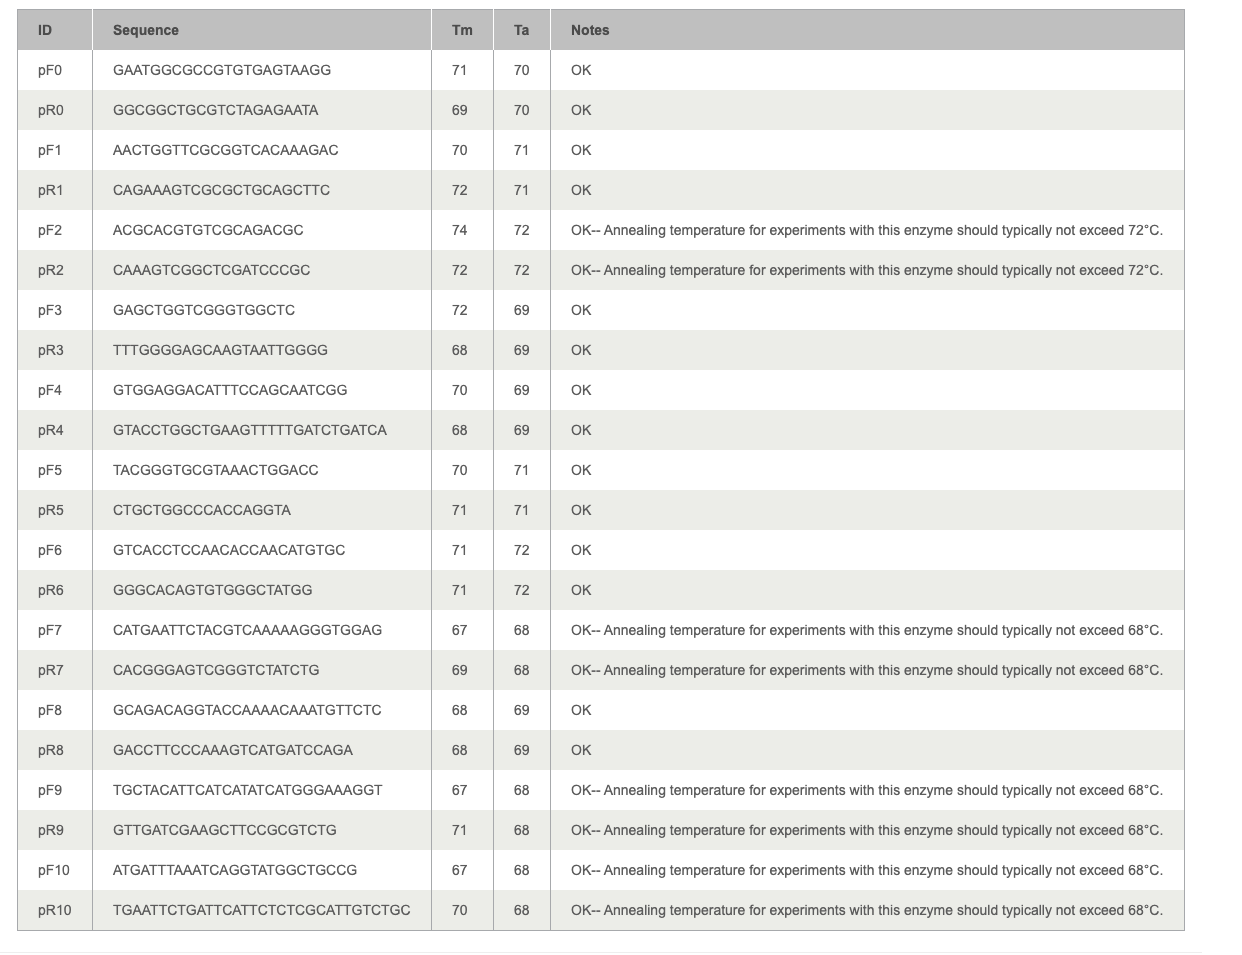